## Exploration des données et pré-traitement

Le but de notre projet est de prédire les prix de logements  airBNB à l'aide de différents modèles de prédiction. Les prix de chaque logement varie en fonctioon de différents critères. Notre but sera de comparer l'influance des variables sur le prix puis d'effectuer la prédiction la plus précise.
Grâce aux données "train" nous allons commencer par pré-traiter les données afin de les rendre utilisables ( détection des valeurs nulles , encodage , suppression des variables sans impact sur le prix).

Une fois les colonnes prêtes à l'usage , nous allons appliquer plusieurs modèles comme la SVM , la régression linéaire ou l'arbre de décision puis récupérer leurs informations ( R^2 et erreur ) afin de déterminer leur précision.

Nous allons finalement choisir le plus précis ( celui avec le R^2 le plus élévé et l'erreur la plus faible ) afin de prédire les prix dans airBNB des données "test".

# Chargement des fichiers et bibliothèques

Bibliothèques :

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Fichiers :

In [310]:
df_train = pd.read_csv("/content/airbnb_train.csv")
df_test = pd.read_csv("/content/airbnb_test.csv")
print(df_train["bed_type"].head(30))

0          Real Bed
1          Real Bed
2          Real Bed
3          Real Bed
4          Real Bed
5          Real Bed
6          Real Bed
7     Pull-out Sofa
8          Real Bed
9          Real Bed
10         Real Bed
11         Real Bed
12         Real Bed
13         Real Bed
14         Real Bed
15         Real Bed
16    Pull-out Sofa
17         Real Bed
18         Real Bed
19         Real Bed
20         Real Bed
21         Real Bed
22         Real Bed
23         Real Bed
24         Real Bed
25         Real Bed
26         Real Bed
27         Real Bed
28         Real Bed
29         Real Bed
Name: bed_type, dtype: object


# Exploration des données

Afin de décider des colonnes que nous allons garder pour notre prédiction, nous allons tout d'abord effectuer un nettoyage afin de pouvoir utiliser les données dans des algorithmes de corrélation, comme les heatmap par exemple. Affichons les 3 premiers logements en entiers, afin de voir quel est le type de chaque colonne et leur aspect :

In [311]:
pd.set_option('display.max_columns', None)
df_train.head(3)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,LA,Large bright airy room with 2 balconies and Ja...,NaN,t,f,NaN,2015-12-12,t,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,NYC,Private room for rent in a six bedroom apt wit...,2017-05-07,t,t,100%,2016-11-04,t,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,DC,"14th st corridor 2br/2ba condo, secure boutiqu...",NaN,t,f,NaN,2016-12-11,t,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0


On peut observer un aperçu de toutes les colonnes du dataset. On remarque des colonnes booléennes (t pour true, f pour false), des colonnes d'entiers (accomodates, beds), ainsi que des chaines de caractères plus ou moins traitables facilement : property_type (apartment, house) ou encore amenities ({"Tv",...}).

Nous avons reçu des logements AirBNB. Il serait intéressant de pouvoir afficher la répartition des types de logements, variable qui semble avoir une  importance considérable dans la future prédiction du prix. Voici la représentation en graphique circulaire des différents types de logements :

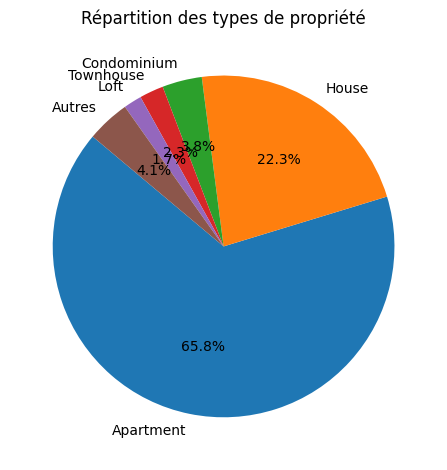

In [312]:
nb_property = df_train["property_type"].value_counts()
top5 = nb_property[:5]
others_sum = nb_property[5:].sum()

prop_pie = pd.concat([top5, pd.Series({"Autres": others_sum})])
prop_pie.plot.pie(autopct="%1.1f%%", startangle=140)
plt.title("Répartition des types de propriété")
plt.ylabel("")
plt.tight_layout()
plt.show()

Les appartements sont majoritaires (65.8%). Les appartements et les maisons représentent presque 90% des logements, ce qui n'est pas étonnant de la part de logements AirBNB.

Analysons les deux colonnes de booléens "host_has_profile_pic" en affichant leur corrélation avec le prix :

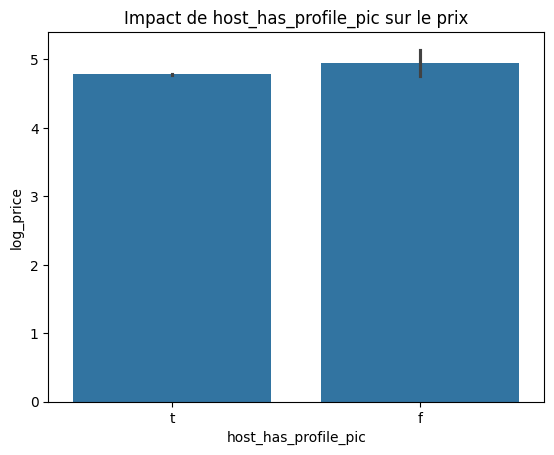

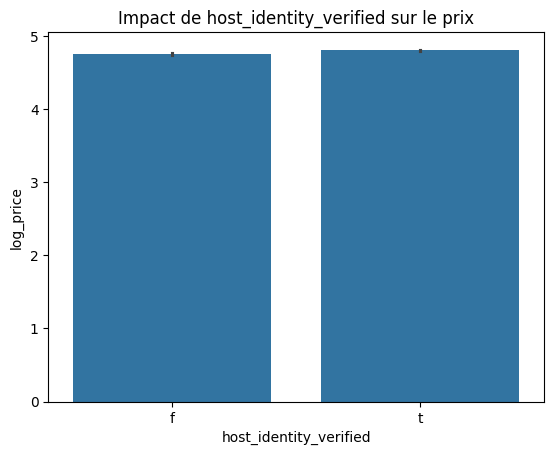

In [313]:
sns.barplot(x=df_train["host_has_profile_pic"], y=df_train["log_price"])
plt.title("Impact de host_has_profile_pic sur le prix")
plt.show()

sns.barplot(x=df_train["host_identity_verified"], y=df_train["log_price"])
plt.title("Impact de host_identity_verified sur le prix")
plt.show()

On remarque que les informations (verification de l'identité et photo de profil ) ne sont pas du tout corrélées avec le prix. Il semble même qu'un utilsateur sans photo de profil affiche un  prix de location légèrement supérieur comparé à celui qui n'en a pas. Le prix et ces deux variables ne sont pas corrélées, on peut supprimer ces deux colonnes.

Ensuite, pour la localisation, nous avons décidé de ne garder que "latitude" et "longitude". En effet, il s'agit de coordonnées, très précises, bien plus précises que "city", "neighborhood" et "zipcode". Nous allons supprimer ces trois colonnes.

Les colonnes "name" et "description" possèdent un trop grand nombre de caractères, ce qui les rend inexploitables. Nous allons supprimer ces deux colonnes qui sont intraitables en machine learning.

Enfin, traitons les colonnes "room_type" et "property_type" en regardant leur impact sur le prix :


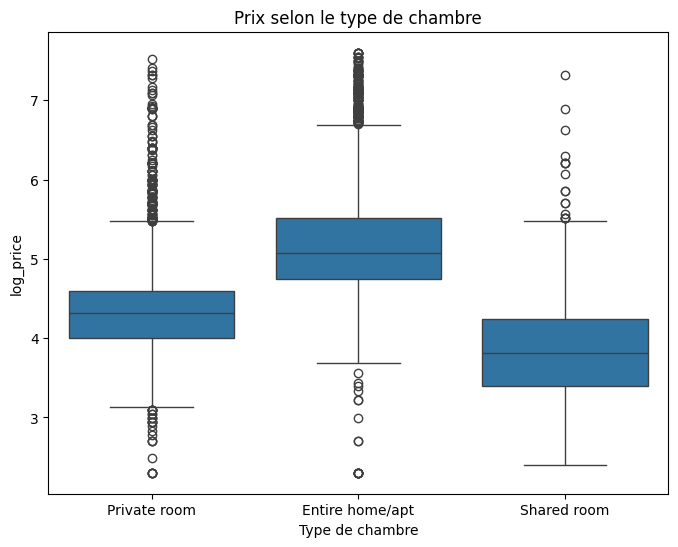

In [314]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="room_type", y="log_price", data=df_train)
plt.title("Prix selon le type de chambre")
plt.xlabel("Type de chambre")
plt.ylabel("log_price")
plt.show()

On remarque une nette corrélation entre le prix et les différents types de chambres ! Nous gardons cette colonne.

Après avoir tenté d'afficher tous les types de logement, nous n'allons afficher que les 8 plus récurrents pour des soucis de visibilité :

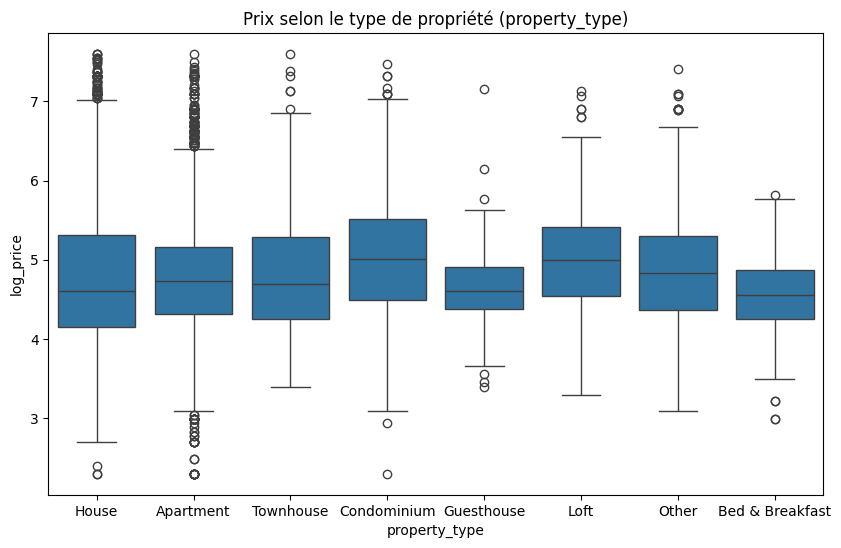

In [315]:
top_properties = df_train["property_type"].value_counts().head(8).index
df_top = df_train[df_train["property_type"].isin(top_properties)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="property_type", y="log_price", data=df_top)
plt.title("Prix selon le type de propriété (property_type)")
plt.xlabel("property_type")
plt.ylabel("log_price")
plt.show()

Idem pour celle ci : le type de logement impacte fortement le prix. Nous la gardons.En effet, un "guest_house" semble moins cher qu'un condominium. Ce sont des informations importantes, que nous devrons encoder par la suite pour les traiter.

La heatmap nous permet directement de voir les corrélations fortes ou faibles entre les colonnes et le prix. En revanche, il ne s'agit que des colonnes exploitables, c'est à dire en int ou double :

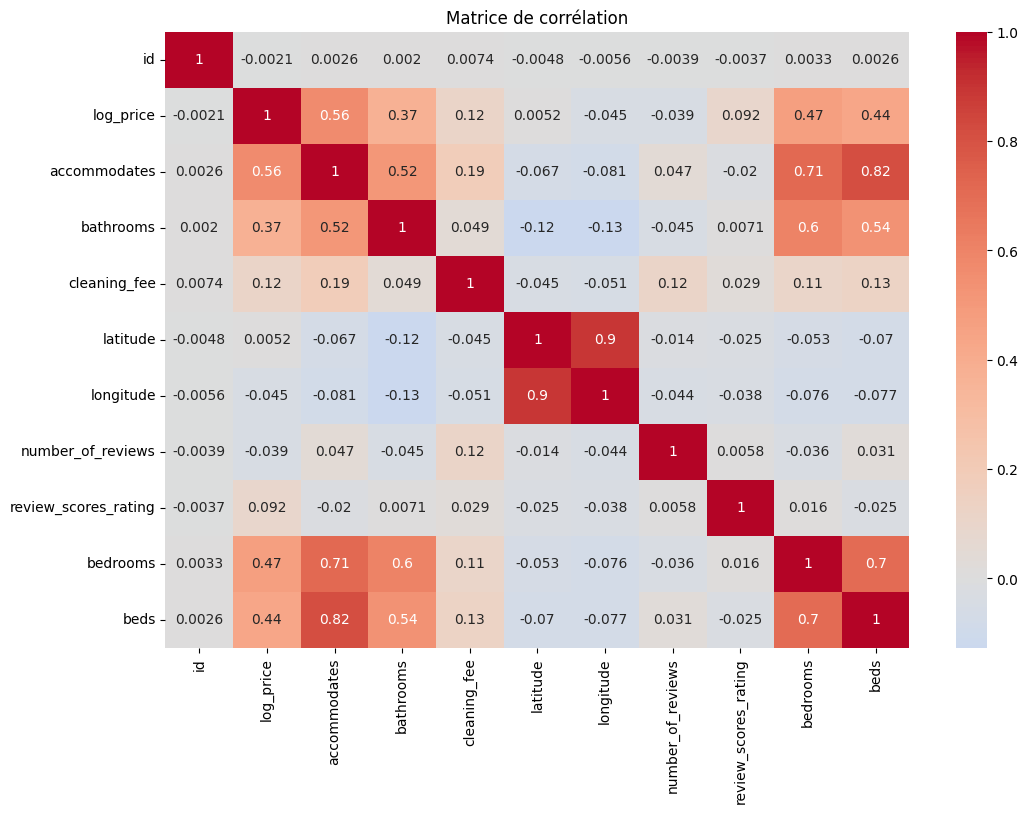

In [316]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()

On observe sans grande surprise les colonnes à grader absolument : accomodates, bathrooms, cleaning fees, bedrooms et beds. On remarque que "number of reviews" n'est pas utile à garder : On aurait pu s'attendre à  corrélation linéaire entre ces deux variables mais ce n'est pas le cas. Cette colonne n'est pas corrélée avec le prix. On peut la supprimer.

# Le choix de la localisation

Nous pouvons afficher la répartition des prix en fonction de la lattitude et longitude, données très précises pour la prédiction du prix d'un bien. Pour cela, on peut zoomer sur une ville en particulier afin de voir la corrélation entre le prix et la lattitude/longitude, en zoomant par exemple entre [-120,-116] et [33.5, 35] :

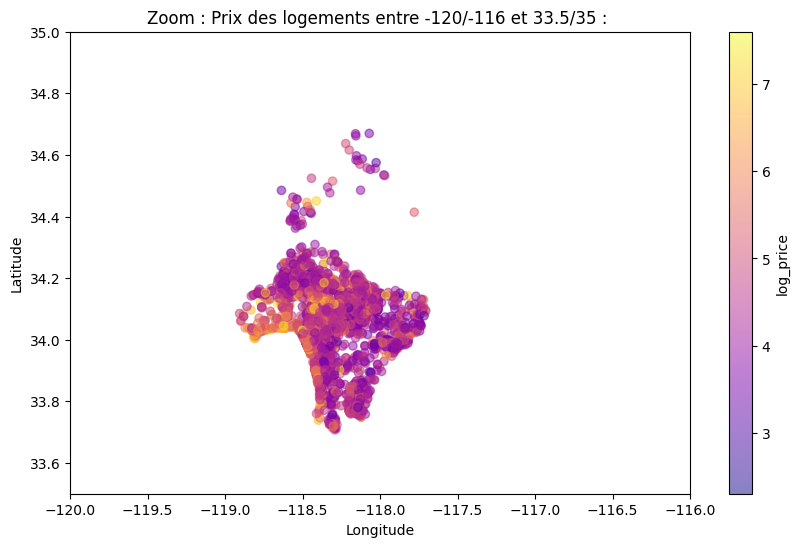

In [317]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train["longitude"], df_train["latitude"],
            c=df_train["log_price"], cmap="plasma", alpha=0.5)
plt.colorbar(label="log_price")
plt.title("Zoom : Prix des logements entre -120/-116 et 33.5/35 : ")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-120, -116)
plt.ylim(33.5, 35)
plt.show()

A travers cette carte, on peut clairement remarquer une tendance : on voit apparaître des prix plus élevés à certains endroits (près de 7), ainsi que des blocs de prix très bas (moins de 4).

La colonne "city" est beaucoup trop peu précise par rapport à la longitude/lattitude, idem pour le zipcode et neighbourhood, trop peu précis et faisant doublon avec les coordonnées.

Nous ne gardons que lattitude et longitude.

# Suppression des colonnes inutiles :

Après avoir regardé l'intégralité des colonnes, nous avons pu garder les principales: room_type, property_type, bedrooms, bathrooms, beds, accomodates, cleaning_fee, latitude, longitude, review_scores_rating, number_of_reviews, instant_bookable, host_response_rate ainsi que log_price évidemment.

Nous allons désormais trier la colonne amenitities: nous aurons alors toutes nos colonnes !



# La colonne amenities

La colonne amenities est sous la forme d'une chaine de caractère, entre accolades {}  possédant différents attributs, parfois entre guillements, parfois sans.

Cette colonne contient des information sûrement importantes sur le prix, mais  celles-ci ne sont pas toutes importantes, certaines sont aussi très peu représentées dans la majorité des annonces.

Voici notre stratégie : nous allons filtrer tout d'abord les 20 attributs les plus fréquents dans la liste des annonces. Ensuite, sur ces 20 attributs, nous allons regarder leur impact, et n'ajouter que les 10 plus impactant sur le prix, en vérifiant manuellement les résultats. En effet il ne s'agira que de colonnes de 0 et 1, et la prédiction peut se tromper en présentant des résultats inchorérents.

Tout d'abord, sélectionnons les 20 attributs les plus présents, en épurant la colonne (supression des accolades et guillemets) en amont :

In [318]:
def extraire_amenities(amenities_str):
    try:
        amenities_str = amenities_str.strip("{}")
        items = [a.strip().strip('"') for a in amenities_str.split(",")]
        return items
    except Exception:
        return []

for df in [df_train, df_test]:
    df["parsed_amenities"] = df["amenities"].apply(extraire_amenities)

In [319]:
all_amenities = df_train["parsed_amenities"].explode()

top_20 = [a for a, _ in Counter(all_amenities).most_common(20)]
for amenity in top_20:
    col = "has_" + amenity.lower().replace(" ", "_").replace("-", "_")
    for df in [df_train, df_test]:
        df[col] = df["parsed_amenities"].apply(lambda x: int(amenity in x))
impact_dict = {}



Ensuite, sur ces 20 attributs, on sélectionne les 10 meilleurs, c'est à dire expliquant le mieux le prix :

In [320]:
for amenity in top_20:
    col = "has_" + amenity.lower().replace(" ", "_").replace("-", "_")
    with_amenity = df_train[df_train[col] == 1]["log_price"].mean()
    without_amenity = df_train[df_train[col] == 0]["log_price"].mean()
    impact_dict[col] = with_amenity - without_amenity
top_impact = sorted(impact_dict.items(), key=lambda x: x[1], reverse=True)[:10]

Enfin, on affiche le résultat :

In [321]:
print("Top 10 équipements les plus liés à un prix élevé :")
print("impact / colonne")
for col, delta in top_impact:
    print(delta," / ",col)

Top 10 équipements les plus liés à un prix élevé :
impact / colonne
0.4207956901984353  /  has_tv
0.41787389146511966  /  has_family/kid_friendly
0.2718159268116418  /  has_heating
0.26990352906135406  /  has_kitchen
0.25295145241149886  /  has_dryer
0.24231867180746125  /  has_washer
0.17374457806716936  /  has_hair_dryer
0.15895761448193202  /  has_iron
0.15497961651610304  /  has_wireless_internet
0.1530911206204566  /  has_shampoo


Et pour terminer, on ne garde que les colonnes correspondantes :

In [322]:
cols_to_keep = [
    "has_tv", "has_family/kid_friendly", "has_heating",
    "has_kitchen", "has_dryer", "has_washer","has_hair_dryer",
    "has_iron", "has_wireless_internet", "has_shampoo"
]
all_has_cols = [col for col in df_train.columns if col.startswith("has_")]
cols_to_drop = list(set(all_has_cols) - set(cols_to_keep))

df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)
print(df_train.columns)
print(df_test.columns)

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'zipcode', 'bedrooms', 'beds',
       'parsed_amenities', 'has_wireless_internet', 'has_kitchen',
       'has_heating', 'has_tv', 'has_shampoo', 'has_washer', 'has_hair_dryer',
       'has_dryer', 'has_iron', 'has_family/kid_friendly'],
      dtype='object')
Index(['Unnamed: 0', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
     

COmme prévu, nous avons désormais l'intégralité de nos colonnes à garder. Nous allons supprimer les colonnes inutiles.

De plus, nous devons supprimer la colonne amenities, qui est restée sous un format indésirable, de même pour "parsed_amenities", qui nous a servi à couper la colonne.

In [323]:
# Supression des colonnes:
colonnes_a_supprimer = [
    "id", "bed_type", "cancellation_policy", "city", "description",
    "first_review", "host_has_profile_pic", "host_identity_verified",
     "host_since", "last_review", "name",
    "neighbourhood", "zipcode", "amenities", "parsed_amenities"
]
colonnes_a_supprimer_test = [col for col in colonnes_a_supprimer if col != "id"]
df_train = df_train.drop(columns=[col for col in colonnes_a_supprimer if col in df_train.columns])
df_test = df_test.drop(columns=[col for col in colonnes_a_supprimer_test if col in df_test.columns])

Nos colonnes sont choisies !

# Nettoyage des colonnes restantes
Ainsi, nous possédons l'intégralité des colonnes sur lesquelles nous allons effectuer les prédictions.



Mais avant cela, nous allons épurer les données des colonnes pour s'assurer du bon formatage des données. En effet, les colonnes doivent être exploitables par les algorithmes de prédiction.


Tout d'abord, remplacons les valeurs  manquantes du dataset par la médiane de la colonne :


In [324]:
print(df_test.isna().sum())

Unnamed: 0                     0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                    149
cleaning_fee                   0
host_response_rate         12824
instant_bookable               0
latitude                       0
longitude                      0
number_of_reviews              0
review_scores_rating       11744
bedrooms                      65
beds                          96
has_wireless_internet          0
has_kitchen                    0
has_heating                    0
has_tv                         0
has_shampoo                    0
has_washer                     0
has_hair_dryer                 0
has_dryer                      0
has_iron                       0
has_family/kid_friendly        0
dtype: int64


On remarque que plusieurs colonnes ont des données nulles. Nous allons les remplacer par la médiane de chaque colonne si possible. De plus, la colonne "host response rate" montre une abscence de plus de 5000 valeurs. Supprimer cette colonne devient un choix judicieux.
Les colonnes bedrooms, batrooms, beds et review scores rating sont déja au format numérique . Elles ne nécessitent de modification.

In [325]:
df_train = df_train.drop(columns = ["host_response_rate"])
df_test = df_test.drop(columns = ["host_response_rate"])

colonnes_numeriques_manquantes = ["bedrooms", "bathrooms", "beds", "review_scores_rating"]
for col in colonnes_numeriques_manquantes:
    mediane_train = df_train[col].median()
    df_train[col] = df_train[col].fillna(mediane_train)

    mediane_test = df_test[col].median()
    df_test[col] = df_test[col].fillna(mediane_test)



La colonne "cleaning fees" contient des booléens. Il faut transformer ces True et False en 0 et 1, exploitables par le machine learning :

In [326]:
for df in [df_train, df_test]:
    df["cleaning_fee"] = df["cleaning_fee"].astype(int)

En revanche, les colonnes room_type, property_type et instant_bookable sont en chaines de caractères, ce qui implique une modification. Nous allons les encoder.
En effet, le nombre de catégories différentes pour chaque colonne est faible (House, appartment, studio, etc, ou encore la 3eme qui est un booléen true/false).

On utlise fit_transform() pour encoder les valeurs de ces colonnes :

In [327]:
colonnes_categorielle = ["room_type", "property_type", "instant_bookable"]
encodeur = LabelEncoder()

for col in colonnes_categorielle:
    df_train[col] = encodeur.fit_transform(df_train[col])
    df_test[col] = encodeur.fit_transform(df_test[col])


print(df_test.head())

   Unnamed: 0  property_type  room_type  accommodates  bathrooms  \
0    14282777              0          0             3        1.0   
1    17029381              0          0             7        1.0   
2     7824740              0          0             5        1.0   
3    19811650             17          0             4        1.0   
4    12410741              0          0             2        1.0   

   cleaning_fee  instant_bookable   latitude   longitude  number_of_reviews  \
0             1                 0  40.696524  -73.991617                  2   
1             1                 1  40.766115  -73.989040                  6   
2             1                 1  40.808110  -73.943756                 10   
3             1                 0  37.772004 -122.431619                  0   
4             1                 1  38.925627  -77.034596                  4   

   review_scores_rating  bedrooms  beds  has_wireless_internet  has_kitchen  \
0                 100.0       1.0   1

Ainsi, nous avons exploré nos données. Nous avions un fichier excel, dont les colonnes concernaient un grand nombre d'informations sur 39 000 logements.

Tout d'abord, nous avons nettoyé nos données. En effet, de nombreuses colonnes possédaient des valeurs inexitantes, ce qui nous a mené a un remplacement de ces valeurs par la médiane de la colonne. Nous avons également mis à jour les colonnes afin que toutes les données soient exploitables par nos futurs algorithmes de prédiction. En effet, ceux-ci ont besoin de nombres pour fonctionner et non des chaines de caractères.

Ensuite, nous avons traité la colonne amenities, qui nécessitait un traitement particulier : une chaine de caractères à décortiquer, possédant des informations modérément importantes mais à ne pas négliger pour augmenter légerement la précision de notre futur algorithme de prédiction. Nous avons transformé cette colonne en plusieurs colonnes binaires exploitables binaire,  par exemple has_TV pour les logements possédant une télévision.

Enfin, une fois le nettoyage effectué, nous avons supprimé les colonnes que nous pensions inutiles, telles que la description du logement, trop difficile à utiliser, host_identity_verified qui n'était pas pertinente, ou encore city qui nous semblait redondante et moins précise que lattitude et longidute, étant donnée notre grande diversité de données. Un dernier nettoyage de pré-traitement a été nécessaire afin de s'assurer de la validité de la base de données . Nous pouvons commencer la prédiction !

## Prédiction

# Suppression des outliers
Nos données contiennent sûrement des valeurs extrêmes. Une donnée avec un prix beaucoup trop élevé ou beaucoup trop bas peut fausser notre prédiction : en effet, le modèle apprendrait sur ces données qui ne reflètent en aucun cas la tendance réelle des prix.

Ainsi, on supprime les 1% des valeurs trop basses et 1% des valeurs trop élevées, de sorte à garder 98% des valeurs pour notre prédiction, ce qui est largement suffisant.

In [328]:
q01 = df_train["log_price"].quantile(0.01)
q99 = df_train["log_price"].quantile(0.99)
df_train = df_train[(df_train["log_price"] >= q01) & (df_train["log_price"] <= q99)]


# Baseline pour la prédiction
Cette étape permet de calculer la précision d'un modèle non entrainé, en prédisant la valeur moyenne des prix à chaque fois.

Nous allons comparer nos algorithmes de prédiction avec ces valeurs, afin de vérifier l'efficacité de l'algorithme .



In [329]:
y_true = df_train["log_price"]
y_pred = [y_true.mean()] * len(y_true)

rmse_baseline = np.sqrt(mean_squared_error(y_true, y_pred))
mae_baseline = mean_absolute_error(y_true, y_pred)
r2_baseline = r2_score(y_true, y_pred)

print("Baseline : prédiction moyenne")
print("RMSE : ",rmse_baseline)
print("MAE : ",mae_baseline)
print("r2 : ",r2_baseline)

Baseline : prédiction moyenne
RMSE :  0.6651373760441296
MAE :  0.5329976924803234
r2 :  0.0


Ce qui est cohérent. Une valeur de 0 pour r2 signifie que le modèle ne prédit rien.

In [330]:
print("Colonnes dans X_train_split :", X_train_split.columns)
print("Colonnes dans X_test :", X_test.columns)

Colonnes dans X_train_split : Index(['property_type', 'room_type', 'accommodates', 'bathrooms',
       'cleaning_fee', 'instant_bookable', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
       'has_wireless_internet', 'has_kitchen', 'has_heating', 'has_tv',
       'has_shampoo', 'has_washer', 'has_hair_dryer', 'has_dryer', 'has_iron',
       'has_family/kid_friendly'],
      dtype='object')
Colonnes dans X_test : Index(['property_type', 'room_type', 'accommodates', 'bathrooms',
       'cleaning_fee', 'instant_bookable', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
       'has_wireless_internet', 'has_kitchen', 'has_heating', 'has_tv',
       'has_shampoo', 'has_washer', 'has_hair_dryer', 'has_dryer', 'has_iron',
       'has_family/kid_friendly'],
      dtype='object')


# Régression linéaire

Première étape : on sépare nos variables, ici la variable à prédire est y = log_price, et nos variables explicatives sont X = toutes les autres colones.On normalise pour avoir des valeurs cohérentes :

In [331]:
X = df_train.drop(columns=["log_price"])
y = df_train["log_price"]
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42)

mean = X_train_split.mean()
std = X_train_split.std()
X_train_std = (X_train_split - mean) / std
X_val_std = (X_val_split - mean) / std


Ensuite on entraine le modèle, et on prédit :

In [332]:
lr_std = LinearRegression()
lr_std.fit(X_train_std, y_train_split)
y_pred_std = lr_std.predict(X_val_std)

Enfin, on analyse les résultats :

In [333]:
rmse_lr = np.sqrt(mean_squared_error(y_val_split, y_pred_std))
mae_lr = mean_absolute_error(y_val_split, y_pred_std)
r2_lr = r2_score(y_val_split, y_pred_std)
print("Régression linéaire: ")
print("RMSE : ",rmse_lr)
print("MAE : ",mae_lr)
print("r2 : ",r2_lr)

Régression linéaire: 
RMSE :  0.452166397176981
MAE :  0.3484402879532801
r2 :  0.534095995634024


Interprétation :     

On remarque une meilleure prédiction globale que pour la baseline. Nous avons une précision de 52.8%, ce qui est mieux que 0 mais loin d'une bonne prédiction.
La MAE, qui correspond à l'erreur moyenne, est de 0.36, soit mieux que pour la baseline, mais correspondant toujours à une erreur  significative.
Enfin, un RMSE de 0.49 indique que les gros écarts de prédiction sont assez importants.
Ces deux nombres doivent être plus faibles pour affirmer avoir une bonne prédiction.

Ce modèle est loin d'être le plus performant.

Intégration de l'analyse en composantes principales

Nous avons intégré une ACP dans le but de projeter les données dans un espace à deux dimension afin de voir les regroupements de données :

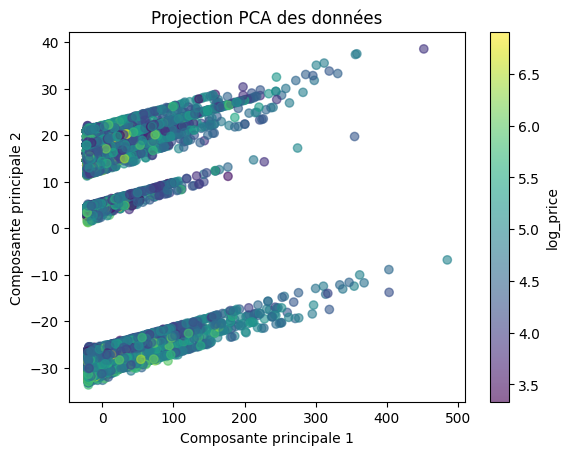

In [334]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.6)
plt.title("Projection PCA des données")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="log_price")
plt.show()

On remarque une présence de "couches" bien délimitées, ce qui montre que l'influence de certaines variables est plus importe  que pour d'autres. Cela confirme l'importance d'utilisation de modèles non-linéaires afin de prédire correctement les prix des logements.

# Random forest avec GridSearch

Tout d'abord, on définit les paramètres de la grille à tester de GirdSearch, et on crée le modèle de base :

In [335]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestRegressor(random_state=42)

Ensuite, on crée le GridSearch, avec bien entendu une validation croisée de 3, ce qui assure une précision plus importante. Et on entraîne le modèle :

In [336]:
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_split, y_train_split)

y_pred_gs = grid_search.predict(X_val_split)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


Enfin, on affiche les résultats :

In [337]:
rmse_rf_gs = np.sqrt(mean_squared_error(y_val_split, y_pred_gs))
mae_rf_gs = mean_absolute_error(y_val_split, y_pred_gs)
r2_rf_gs= r2_score(y_val_split, y_pred_gs)

print("Random Forest optimisée avec GridSearch ")
print(f"RMSE : ", rmse_rf_gs)
print(f"MAE  : ",mae_rf_gs)
print(f"R²   : ", r2_rf_gs)

Random Forest optimisée avec GridSearch 
RMSE :  0.3759759712748958
MAE  :  0.27978070119790005
R²   :  0.6778782469465958


Interprétation :      

On observe une précision de 68%, un résultat   meilleur que celui obtenu par la régression linéaire  mais que nous pouvons encore améliorer . L'erreur MAE a diminué, ce qui valide la meilleure performance de  modèle par rapport à celui de la régression linéaire.

En revanche, nous allons tester d'autres modèles afin d'espérer obtenir
 une meilleure prédiction.

# Arbre de décision (DecisionTreeRegressor):

Nous allons entrainer un arbre de décision simple de profondeur 3, pour déterminer les critères de décision afin de prédire le prix le mieux possible:

On crée le modèle et on l'entraîne :

In [338]:
tree = DecisionTreeRegressor(max_depth= 3,random_state=42)  # max_depth limité pour visualiser facilement
tree.fit(X_train_split, y_train_split)
y_pred_tree = tree.predict(X_val_split)

Et on l'évalue :

In [339]:
rmse_dt = np.sqrt(mean_squared_error(y_val_split, y_pred_tree))
mae_dt = mean_absolute_error(y_val_split, y_pred_tree)
r2_dt = r2_score(y_val_split, y_pred_tree)

print("Arbre de décision : ")
print(f"RMSE : ", rmse_dt)
print(f"MAE  : ",mae_dt)
print(f"R²   : ", r2_dt)

Arbre de décision : 
RMSE :  0.4610275863026135
MAE  :  0.35678671951695845
R²   :  0.5156562501896306


Afin d'avoir un meilleur apercu de l'arbre, nous pouvons l'afficher, étant donné qu'il est de profondeur 3 seulement :

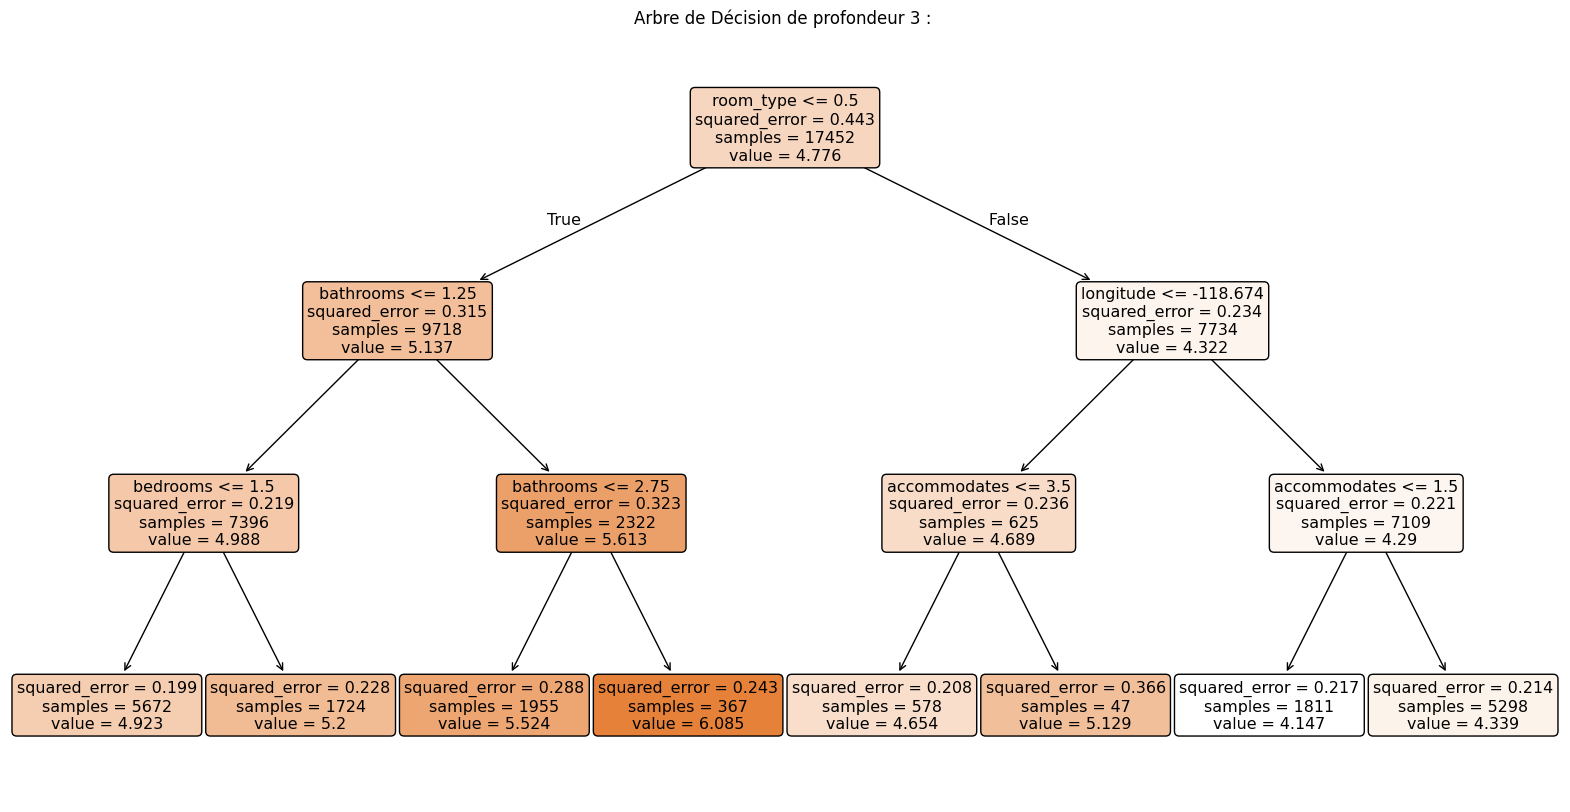

In [340]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train_split.columns, filled=True, rounded=True)
plt.title("Arbre de Décision de profondeur 3 : ")
plt.show()


On peut voir ici concrètement les étapes de l'arbre de décision. En revanche, la précision du modèle est plutot faible. En effet, l'arbre étant seulement de taille 3, cela impacte la précision des résultats.

En testant l'arbre avec une profondeur de 10, on observe une précision de 55%, ce qui est plus élevé que pour une profondeur de 3. En revanche, si l'arbre est trop grand, avec une profondeur de 20 par exemple, la précision chute à 35%. En effet si la profondeur est trop importante, l'arbre de décision sur-apprend ce qui n'est pas souhaitable.

# Support vector machine

Enfin, nous allons entrainer notre dernier modèle : le SVM, support vector machine. Pour cela, nous créons notre modèle :

In [341]:
svr = SVR(kernel="rbf", C=1.0, epsilon=0.2)

Puis, nous l'entraînons sur nos données :

In [342]:
svr.fit(X_train_std, y_train_split)
y_pred_svr = svr.predict(X_val_std)

Nous obtenons ainsi notre SVM. Nous pouvons, comme pour les modèles précédents, afficher la précision (l'erreur RMSE, MAE ainsi que la précision du modèle R2) :

In [343]:
rmse_svm = np.sqrt(mean_squared_error(y_val_split, y_pred_svr))
mae_svm = mean_absolute_error(y_val_split, y_pred_svr)
r2_svm = r2_score(y_val_split, y_pred_svr)

print("Résultats SVR :")
print(f"RMSE : ",rmse_svm)
print(f"MAE  : ",mae_svm)
print(f"R²   : ",r2_svm)

Résultats SVR :
RMSE :  0.42668881749782395
MAE  :  0.3262103564417705
R²   :  0.5851200983895328


On observe une précision de 58% pour notre SVM, ce qui est une précision correcte sans être particulièrement élevée. Le modèle semble plus performant que tous les modèles sauf la forêt aléatoire (random forest). En effet celle-ci possède une précision de 68%.

# Comparaison des différents modèles

In [344]:
resultats = pd.DataFrame([
    {"Modèle": "Baseline",           "RMSE": rmse_baseline, "MAE": mae_baseline, "R²": r2_baseline},
    {"Modèle": "Régression linéaire","RMSE": rmse_lr,       "MAE": mae_lr,       "R²": r2_lr},
    {"Modèle": "Arbre de décision",  "RMSE": rmse_dt,       "MAE": mae_dt,       "R²": r2_dt},
    {"Modèle": "Random Forest ", "RMSE": rmse_rf_gs,    "MAE": mae_rf_gs,    "R²": r2_rf_gs},
    {"Modèle": "Support vector machine ","RMSE": rmse_svm,          "MAE": mae_svm,          "R²": r2_svm}
])

On affiche le tableau par ordre décroissant sur R2 afin d'obtenir la liste des modèles plus performants aux moins performants :

In [345]:
resultats = resultats.sort_values(by="R²", ascending=False).reset_index(drop=True)
print(resultats)

                    Modèle      RMSE       MAE        R²
0           Random Forest   0.375976  0.279781  0.677878
1  Support vector machine   0.426689  0.326210  0.585120
2      Régression linéaire  0.452166  0.348440  0.534096
3        Arbre de décision  0.461028  0.356787  0.515656
4                 Baseline  0.665137  0.532998  0.000000


Comme on a pu le voir précédemment, le modèle de la random forest est le plus performant, avec un score de 68% de précision, ce qui est un score très convenable compte tenu des données fournies.

De plus, on remarque que plus la précision du modèle augmente, plus les erreurs MRSE et MAE sont faibles, ce qui est cohérent. Tous les modèles sont plus précis que la baseline, possédant une précision de 0%, et ont une erreur plus faible, ce qui confirme nos résultats.

# Génération du fichier de prédiction

Désormais, nous avons notre modèle performant : la random forest. Nous devons alors l'appliquer à notre fichier airbnb_test, afin de générer le log_price de tous ses logements.

Tout d'abord, nous avons quelques ajustements à faire sur airbnb_test. Nous devons normaliser ces données, car cela n'a pas encore été fait.

De plus, les colonnes se sont retrouvées dans le désordre, or nous avons besoin de l'allignements des données des deux fichiers pour obtenir la prédiction. Nous ordonnons les colonnes pour avoir la meme structure des deux données.

In [346]:
X_test = df_test[X_train_split.columns]
X_test_std = (X_test - mean) / std

Nous avons mis en place la random forest à l'aide des "super paramètres" issus de la grid search. Nous pouvons alors accéder au modèle de la random forest en utilisant le modèle entrainé "grid_search.best_estimator_.predict()". Cette fonction représente le modèle entraîné à l'aide de la random forest de grid search :

In [347]:
y_pred_test = grid_search.best_estimator_.predict(X_test_std)

predictions_finales = pd.DataFrame({
    "": df_test["Unnamed: 0"],
    "logpred": y_pred_test
})

predictions_finales.to_csv("airbnb_predictions_finales.csv", index=False)


## Conclusion

Ainsi, nous avons réalisé une prédiction sur le prix de logements airbnb à l'aide de leur données qui nous ont été fournies. Nous possédions un fichier rempli de plusieurs dizaines de colonnes, et nous avons appliqué un pré-traitement pour ensuite appliquer un modèle de prédiction pour obtenir des prédictions les plus précises possibles.

Pour cela, nous avons observé nos données dans un premier temps : de nombreuses colonnes, du nombre de lit à la description de l'hôte, en passant par le type de logement. Nous avons alors détecté des colonnes booléennes (true false), des colonnes en chaine de caractère (notamment la colonne amenities), ainsi que d'autres en nombres (entiers ou décimaux). Nous avons du sélectionner les colonnes les plus importantes. Pour cela, nous avons pu afficher différents graphiques représentant plusieurs colonnes puis nous les avons comparé et étudié leur impact sur le prix du logement. Certaines semblaient inutiles : c'est le cas "host_has_profile_pic", colonne n'influant en aucun sur le prix. De plus  les colonnes de localisation, trop nombreuses, nous ont poussé à choisir des plus précises : longitude et lattitude, en doublon par rapport à la ville et au quartier. Nous avons du étudier le cas de la colonne "amenities", possédant de nombreuses informations. Nous avons étudié celles influant le plus sur le prix. Une information sous-représentée en terme d'effectif mais avec un gros impact sur le prix aurait pu fausser la tendance moyenne de prédiction.

Ensuite, une fois les colonnes sélectionnées, nous avons du en nettoyer une grande partie : la colonne "host_response_rate" présentant plus de 5000 valeurs manquantes pouvait être supprimée. Nous avons ensuite remplacé les valeurs manquantes par la médiane de leur colonne afin d'obtenir des valeurs utilisables pour nos modèles de prédiction. De plus, les colonnes en chaine de caractère et en booléens ont été traitées, de sorte à les remplacer par des nombres afin de garantir leur utilisation dans nos modèles par la suite. Ainsi, nous avons nos colonnes choisies, traitées, nettoyées, prête à l'usage par des algorithmes de prédiction.

Enfin, nous avons appliqué ces fameux modèles que nous avons utilisés en TD. Tout d'abord, nous avons défini une baseline, modèle "de base", sans aucune prédiction afin de vérifier si les modèles sont plus efficace qu'un simple test de prédiction avec la moyenne totale. Une fois la baseline définie, nous avons normalisé nos données, afin d'avoir des valeurs de même poids. Nous avons également supprimé 2% des données, celles dont le prix semblait beaucoup trop important ou beaucoup trop faible par rapport aux autres. Nous avons ainsi supprimé les "outliers", qui peuvent fausser les résultats (il s'agit par exemple d'anonces mensongères, ou d'erreur de la part des hôtes).
Nous avons alors appliqué successivement nos différents modèles: la régression linéaire, l'arbre de décision, la random forest ainsi que le support vector machine, en analysant leur RMSE, erreur quadratique moyenne, MAE, erreur absolue moyenne, et la précision du modèle, R2. Nous avons comparé ces résultats.

Nous en avons conclu que la random forest est le meilleur modèle de prédiction, avec une prédiction de 68%, comparé à 51, 53 et 58 pour les autres modèles (voir tableau). L'erreur est également minimisée avec la random forest : RMSE = 0.37, MAE = 0.27. Il s'agit bien du meilleur modèle. Nous avons pu alors générer notre fichier de prédiction, en utlisant ce modèle entrainé par la random forest amélioré par gird search et ses super paramètres.

Ainsi, nous avons prédit les prix de logements air BNB.